In [1]:
# Step 1: Install PyTorch Geometric
!pip install torch_geometric
!pip install torchviz

/usr/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point
     |████████████████████████████████| 661 kB 1.1 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=c59693813edec651453f76c10f9e49f162389be998f44603d1d1494a0e4a7585
  Stored in directory: /home/prabir/.cache/pip/wheels/ff/6c/d6/f131acff9176ff91cb7ce97ddcd7170182c99533bf31c86a1d
Successfully built torch-geometric
/usr/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point
     |████████████████████████████████| 47 kB 954 kB/s eta 0:00:01
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-non

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import numpy as np

In [3]:
# Load Cora dataset
dataset = Planetoid(root="/tmp/Cora", name="Cora")
data = dataset[0]

Processing...
Done!


In [4]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [5]:
print("node vectors: \n", data.x, "\n")
print("node classes:  \n", data.y, "\n")
print("edge indeces: \n", data.edge_index, "\n\n\n")

print("train_mask: \n", data.train_mask, "\n")
print("val_mask: \n", data.val_mask, "\n")
print("test_mask: \n", data.test_mask, "\n")

node vectors: 
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) 

node classes:  
 tensor([3, 4, 4,  ..., 3, 3, 3]) 

edge indeces: 
 tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]]) 



train_mask: 
 tensor([ True,  True,  True,  ..., False, False, False]) 

val_mask: 
 tensor([False, False, False,  ..., False, False, False]) 

test_mask: 
 tensor([False, False, False,  ...,  True,  True,  True]) 



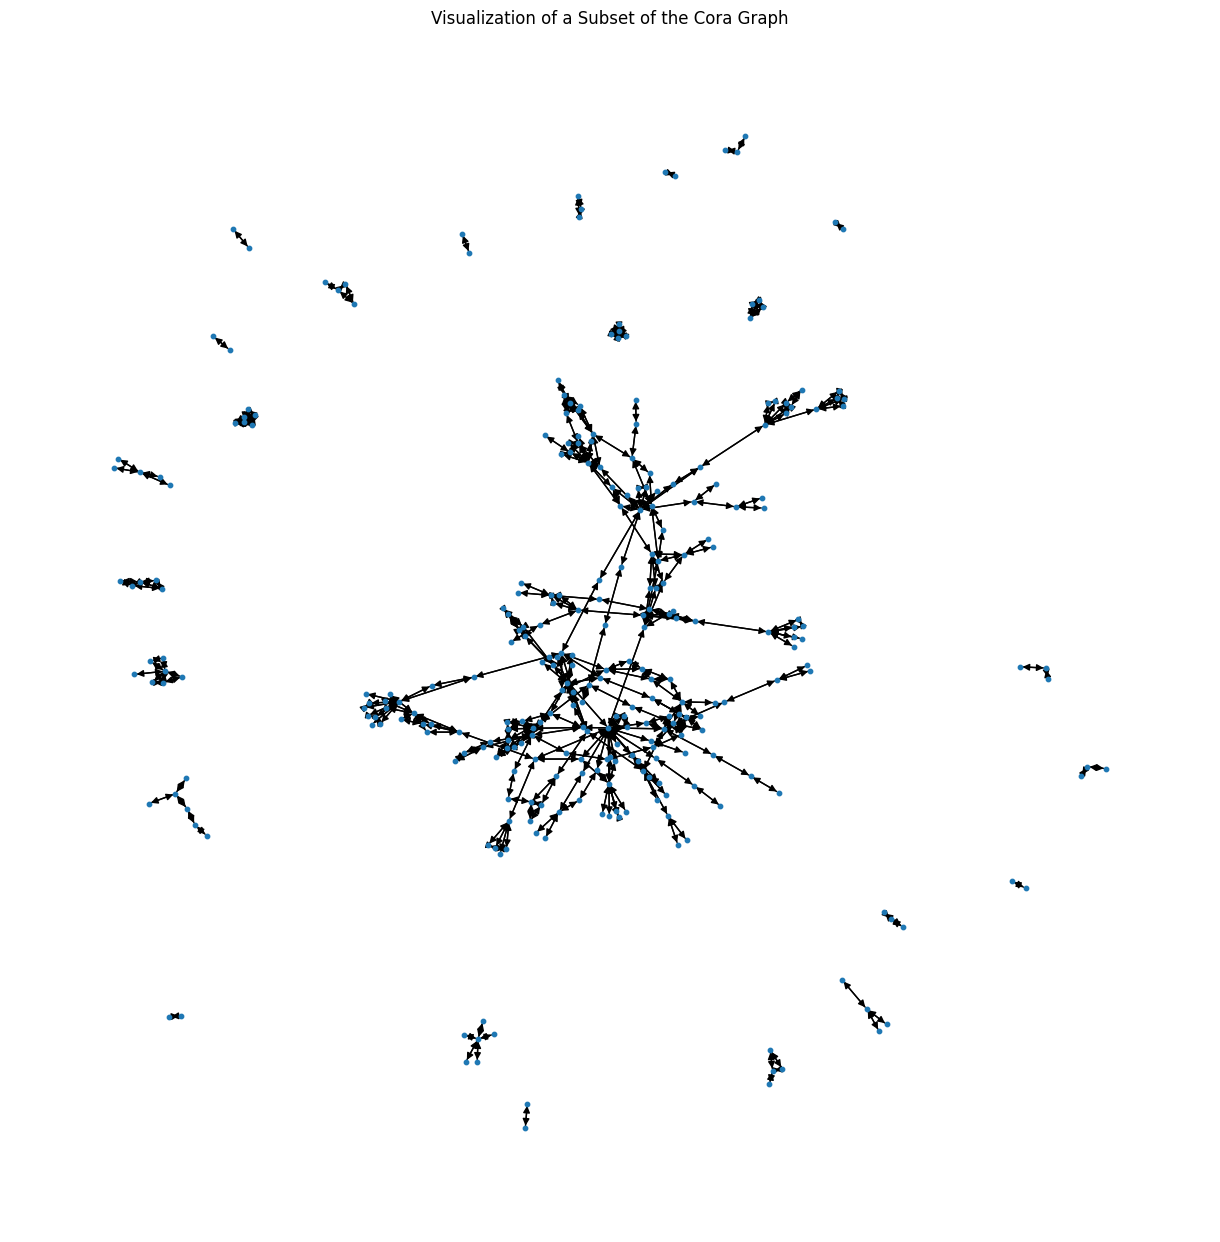

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert to networkx graph
G = nx.DiGraph()
for i, j in zip(*data.edge_index):
    G.add_edge(i.item(), j.item())

# Draw a subset of the graph (e.g., first 300 nodes)
subset_nodes = list(G.nodes)[:300]
subset_graph = G.subgraph(subset_nodes)

plt.figure(figsize=(12, 12))
nx.draw(subset_graph, with_labels=False, node_size=10)
plt.title("Visualization of a Subset of the Cora Graph")
plt.show()

In [7]:
# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [8]:
# Training and evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(hidden_channels=16).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [9]:
import matplotlib.pyplot as plt


# Lists to store loss and accuracy over time
train_loss_history = []
test_accuracy_history = []


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[data.test_mask] == data.y[data.test_mask]
    acc = int(correct.sum()) / int(data.test_mask.sum())
    return acc


for epoch in range(300):
    loss = train()
    train_loss_history.append(loss)
    accuracy = test()
    test_accuracy_history.append(accuracy)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

print("Test Accuracy:", test())

Epoch: 000, Loss: 1.9465, Accuracy: 0.4350
Epoch: 010, Loss: 0.6053, Accuracy: 0.7990
Epoch: 020, Loss: 0.1193, Accuracy: 0.7970
Epoch: 030, Loss: 0.0307, Accuracy: 0.8020
Epoch: 040, Loss: 0.0234, Accuracy: 0.8020
Epoch: 050, Loss: 0.0170, Accuracy: 0.8020
Epoch: 060, Loss: 0.0183, Accuracy: 0.8080
Epoch: 070, Loss: 0.0257, Accuracy: 0.8150
Epoch: 080, Loss: 0.0192, Accuracy: 0.8030
Epoch: 090, Loss: 0.0184, Accuracy: 0.8170
Epoch: 100, Loss: 0.0183, Accuracy: 0.8130
Epoch: 110, Loss: 0.0206, Accuracy: 0.8060
Epoch: 120, Loss: 0.0163, Accuracy: 0.8170
Epoch: 130, Loss: 0.0138, Accuracy: 0.8070
Epoch: 140, Loss: 0.0193, Accuracy: 0.8150
Epoch: 150, Loss: 0.0153, Accuracy: 0.8080
Epoch: 160, Loss: 0.0170, Accuracy: 0.8100
Epoch: 170, Loss: 0.0140, Accuracy: 0.8130
Epoch: 180, Loss: 0.0117, Accuracy: 0.8030
Epoch: 190, Loss: 0.0116, Accuracy: 0.8150
Epoch: 200, Loss: 0.0133, Accuracy: 0.8080
Epoch: 210, Loss: 0.0127, Accuracy: 0.8040
Epoch: 220, Loss: 0.0118, Accuracy: 0.8100
Epoch: 230,

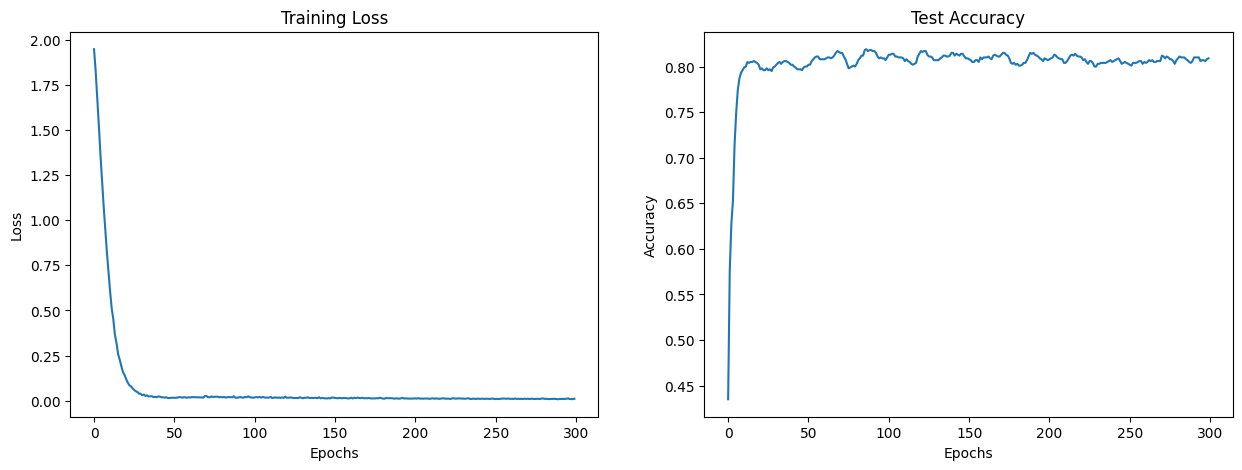

In [10]:
# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_loss_history)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")

ax2.plot(test_accuracy_history)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Test Accuracy")

plt.show()